```{index} single: application; airline seating allocation
```
```{index} single: solver; cbc
```
```{index} pandas dataframe
```
```{index} single: Pyomo; sets
```
```{index} stochastic optimization
```
```{index} chance constraints
```
```{index} sample average approximation
```
```{index} two-stage problem
```

# Airline seat allocation problem

## Attribution

The following problem statement is adapted from an exercise and examples presented by Birge and Louveaux (2011). 

* Birge, J. R., & Louveaux, F. (2011). Introduction to stochastic programming. Springer Science & Business Media.

The adaptations include a change to parameters for consistency among reformulations of the problem, and additional treatments for sample average approximation (SAA) with chance constraints.

## Problem Statement

An airline is deciding how to partition a new plane for the Amsterdam-Buenos Aires route. This plane can seat 200 economy class passengers. A section can be created for first class seats, but each of these seats takes the space of 2 economy class seats. A business class section can also be created, but each of these takes the space of 1.5 economy class seats. The profit for a first class ticket is three times the profit of an economy ticket, while a business class ticket has a profit of two times an economy ticket's profit. Once the plane is partitioned into these seating classes, it cannot be changed. 

The airlines knows that the plane will not always be full in every section. The airline has initially identified three scenarios to consider with about equal frequency: 

1. Weekday morning and evening traffic.
2. Weekend traffic.
3. Weekday midday traffic. 

Under Scenario 1 the airline thinks they can sell as many as 20 first class tickets, 50 business class tickets, and 200 economy tickets. Under Scenario 2 these figures are 10 , 24, and 175, while under Scenario 3, they are 6, 10, and 150, respectively. The following table summarizes the forecast demand for these three scenarios.

| Scenario | First class seats | Business class seats | Economy class seats |
| :-- | :-: | :-: | :-: |
| (1) weekday morning and evening | 20 | 50 | 200 |
| (2) weekend | 10 | 24 | 175 |
| (3) weekday midday | 6 | 10 | 150 |
| **Mean Scenario** | **12** | **28** | **175** |

For marketing purposes, the airline will not sell more tickets than seats in each of the sections (hence no overbooking strategy). We further assume customers seeking a first-class or business class seat will not downgrade if those seats are not available.

Implement and solve the extensive form of the stochastic program for the optimal seat allocation aiming to maximize the airline profit.

## Installation and Imports

In [1]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_cbc()

pyomo was previously installed
cbc was previously installed


True

In [2]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Problem Data

Pandas DataFrames and Series are used to encode problem data in the following cell, and to encode problem solutions in subsequent cells.

In [3]:
# scenario data
demand = pd.DataFrame({
    "morning and evening": {'F': 20, 'B': 50, 'E': 200},
    "weekend": {'F': 10, 'B': 24, 'E': 175},
    "midday": {'F':  6, 'B': 10, 'E': 150}
}).T

# global revenue and seat factor data
capacity = 200
revenue_factor = pd.Series({"F": 3.0, "B": 2.0, "E": 1.0})
seat_factor = pd.Series({"F": 2.0, "B": 1.5, "E": 1.0})

## Analytics

Prior to optimization, a useful first step is to prepare an analytics function to display performance for any given allocation of seats. The first-stage decision variables are the number of seats allocated for each class $c\in C$. We would like to provide a analysis showing the operational consequences for any proposed allocation of seats. For this purpose, we create a function ``seat_report()`` that show the tickets that can be sold in each scenario, the resulting revenue, and the unsatisfied demand ('spillage'). 

To establish a basis for analyzing possible solutions to the airline's problem, this function first is demonstrated for the case where the airplane is configured as entirely economy class.


Seat Allocation


,F,B,E,TOTAL
seat allocation,0.0,0.0,200.0,200.0
economy equivalent seat allocation,0.0,0.0,200.0,200.0



Tickets Sold


,F,B,E
morning and evening,0,0,200
weekend,0,0,175
midday,0,0,150



Seats not Sold


,F,B,E
morning and evening,0,0,0
weekend,0,0,25
midday,0,0,50



Spillage (Unfulfilled Demand)


,F,B,E
morning and evening,20,50,0
weekend,10,24,0
midday,6,10,0



Expected Revenue (in units of economy ticket price): 175.00


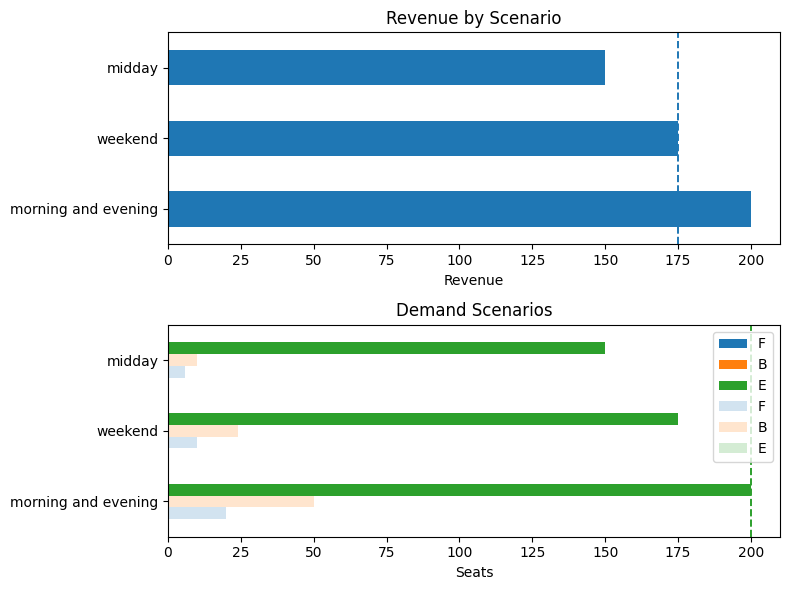

In [4]:
# function to report analytics for any given seat allocations
def seat_report(seats, demand):
    
    classes = seats.index
    
    # report seat allocation
    equivalent_seats = pd.DataFrame({
        "seat allocation":  {c: seats[c] for c in classes},
        "economy equivalent seat allocation": {c: seats[c] * seat_factor[c] for c in classes}
    }).T
    equivalent_seats["TOTAL"] = equivalent_seats.sum(axis=1)
    print("\nSeat Allocation")
    display(equivalent_seats)
    
    # tickets sold is the minimum of available seats and demand
    tickets = pd.DataFrame()
    for c in classes:
        tickets[c] = np.minimum(seats[c], demand[c])
    print("\nTickets Sold")
    display(tickets)
    
    # seats unsold
    unsold = pd.DataFrame()
    for c in classes:
        unsold[c] = seats[c] - tickets[c]
    print("\nSeats not Sold")
    display(unsold)

    # spillage (unmet demand)
    spillage = demand - tickets
    print("\nSpillage (Unfulfilled Demand)")
    display(spillage)
    
    # compute revenue
    revenue = tickets.dot(revenue_factor)
    print(f"\nExpected Revenue (in units of economy ticket price): {revenue.mean():.2f}")

    # charts
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    revenue.plot(ax=ax[0], kind="barh", title="Revenue by Scenario")
    ax[0].plot([revenue.mean()]*2, ax[0].get_ylim(), "--", lw=1.4)
    ax[0].set_xlabel("Revenue")
    
    tickets[classes].plot(ax=ax[1], kind="barh", rot=0, stacked=False, title="Demand Scenarios")
    demand[classes].plot(ax=ax[1], kind="barh", rot=0, stacked=False, title="Demand Scenarios", alpha=0.2)
    for c in classes:
        ax[1].plot([seats[c]] * 2, ax[1].get_ylim(), "--", lw=1.4)
    ax[1].set_xlabel("Seats")
    
    fig.tight_layout()

    return

# a trial solution 
seats_all_economy = pd.Series({"F": 0, "B": 0, "E": 200})
seat_report(seats_all_economy, demand)

## Model 1. Deterministic Solution for the Average Scenario

A common starting point in stochastic programming is to solve the deterministic problem where future demands are fixed at their mean values, then computing the expected value that results when using that solution. The resulting value of the objective has been called the *expectation of the expected value probem (EEV)* by Birge, or the *expected value of the mean (EVM)* solution by others.

The objective function is to maximize ticket revenue.

$$
\begin{align}
\max_{\text{seats}_c, \text{tickets}_c} & \sum_{c\in \text{CLASSES}} r_c \text{tickets}_c 
\end{align}
$$

where $r_c$ is the revenue from selling a ticket for a seat in class $c\in \text{CLASSES}$. 

Let $\text{seats}_c$ denote the number of seats of class $c \in \{F, B, E\}$ installed in the new plane. Let $s_c$ be the scale factor denoting the number of economy seats displaced by one seat in class $c$. Then

$$
\begin{align}
\sum_{c\in \text{CLASSES}} s_c \text{seats}_c & \leq \text{capacity}
\end{align}
$$

where $\text{capacity}$ is the total number of economy class seats that could fit on the plane. Let $\bar{\text{demand}}_c$ be the mean demand for seats of class $c\in \text{CLASSES}$, and let $\text{tickets}_c$ be the number of tickets of class $c\in \text{CLASSES}$ that are sold. Then

$$
\begin{align}
\text{tickets}_c & \leq \text{seats}_c & \forall c\in \text{CLASSES} \\
\text{tickets}_c & \leq \text{mean demand}_c & \forall c\in \text{CLASSES}
\end{align}
$$

The following cell presents a Pyomo model implementing this model.


Seat Allocation


,F,B,E,TOTAL
seat allocation,12.0,28.0,134.0,174.0
economy equivalent seat allocation,24.0,42.0,134.0,200.0



Tickets Sold


,F,B,E
morning and evening,12.0,28.0,134.0
weekend,10.0,24.0,134.0
midday,6.0,10.0,134.0



Seats not Sold


,F,B,E
morning and evening,0.0,0.0,0.0
weekend,2.0,4.0,0.0
midday,6.0,18.0,0.0



Spillage (Unfulfilled Demand)


,F,B,E
morning and evening,8.0,22.0,66.0
weekend,0.0,0.0,41.0
midday,0.0,0.0,16.0



Expected Revenue (in units of economy ticket price): 203.33


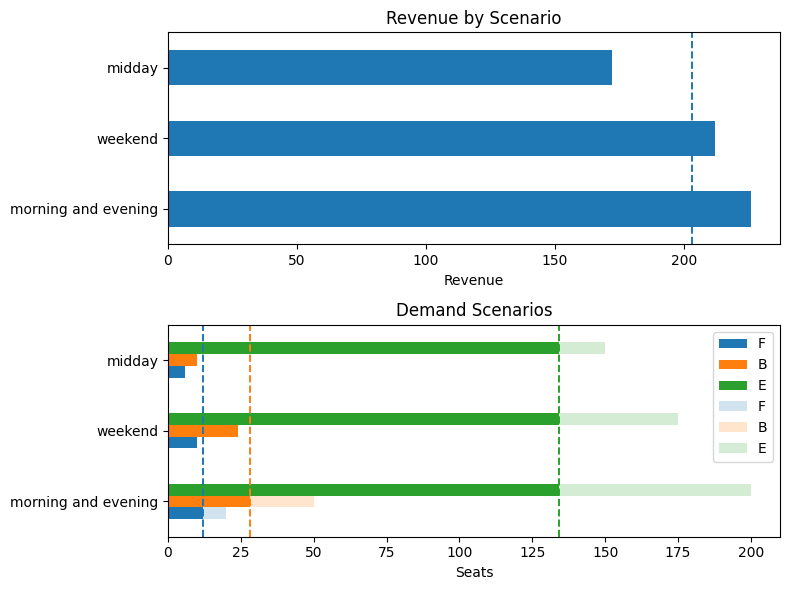

In [5]:
def airline_EEV(demand):

    m = pyo.ConcreteModel()
    
    m.CLASSES = pyo.Set(initialize=demand.columns)

    # first stage variables and constraints
    m.seats = pyo.Var(m.CLASSES, domain=pyo.NonNegativeIntegers) 

    @m.Constraint(m.CLASSES)
    def plane_seats(m, c):
        return sum(m.seats[c] * seat_factor[c] for c in m.CLASSES) <= capacity

    # second stage variable and constraints
    m.tickets = pyo.Var(m.CLASSES, domain=pyo.NonNegativeIntegers)

    @m.Constraint(m.CLASSES)
    def demand_limits(m, c):
        return m.tickets[c] <= demand[c].mean()

    @m.Constraint(m.CLASSES)
    def seat_limits(m, c):
        return m.tickets[c] <= m.seats[c]

    # objective
    @m.Objective(sense=pyo.maximize)
    def revenue(m):
        return sum(m.tickets[c] * revenue_factor[c] for c in m.CLASSES)
    
    return m

def airline_solve(m):
    pyo.SolverFactory('cbc').solve(m)
    return pd.Series({c: m.seats[c]() for c in m.CLASSES})

model_eev = airline_EEV(demand)
seats_eev = airline_solve(model_eev)
seat_report(seats_eev, demand)

## Model 2. Extensive Form of a Stochastic Program

The stochastic program accounts for uncertainty in demand by treating the number of tickets sold as scenario dependent, i.e., a second-stage or recourse decision variable, $\text{tickets}_{c,s}$ that is indexed by both seat class and scenario. 

$$
\begin{align}
\max & \frac{1}{N}\sum_{\substack{c\in \text{CLASSES} \\ s\in \text{SCENARIOS}}} r_c \text{tickets}_{c, s} 
\end{align}
$$

where $N$ is the number of scenarios. The first stage constraint remains unchanged

$$
\begin{align}
\sum_{c\in \text{CLASSES}} s_c \text{seats}_c & \leq \text{capacity}
\end{align}
$$

The second stage constraints are

$$
\begin{align}
\text{tickets}_c & \leq \text{seats}_c & \forall c\in \text{CLASSES} \\
\text{tickets}_c & \leq \text{demand}_{c, s} & \forall (c, s) \in \text{CLASSES} \times \text{SCENARIOS}
\end{align}
$$

The following cell presents a Pyomo model implementing this model.


Seat Allocation


,F,B,E,TOTAL
seat allocation,10.0,20.0,150.0,180.0
economy equivalent seat allocation,20.0,30.0,150.0,200.0



Tickets Sold


,F,B,E
morning and evening,10.0,20.0,150.0
weekend,10.0,20.0,150.0
midday,6.0,10.0,150.0



Seats not Sold


,F,B,E
morning and evening,0.0,0.0,0.0
weekend,0.0,0.0,0.0
midday,4.0,10.0,0.0



Spillage (Unfulfilled Demand)


,F,B,E
morning and evening,10.0,30.0,50.0
weekend,0.0,4.0,25.0
midday,0.0,0.0,0.0



Expected Revenue (in units of economy ticket price): 209.33


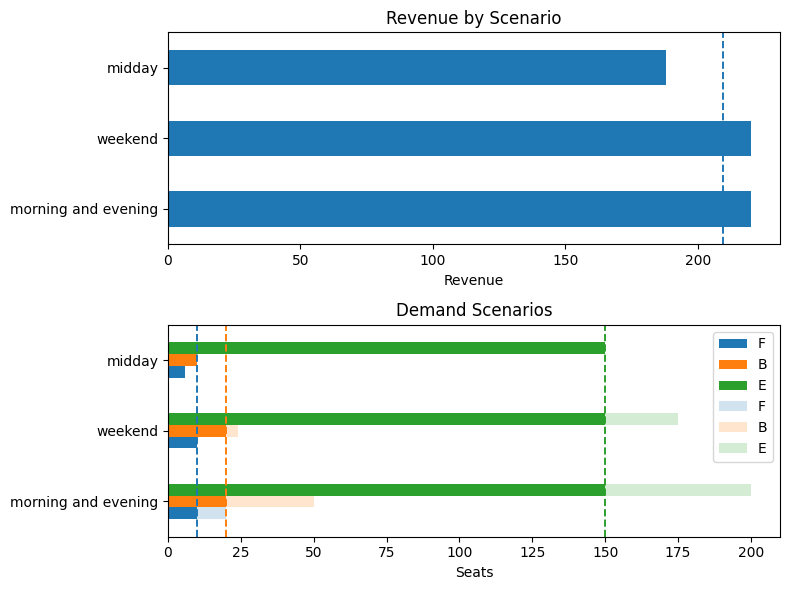

In [6]:
def airline_SS(demand):

    m = pyo.ConcreteModel()
    
    m.CLASSES = pyo.Set(initialize=demand.columns)
    m.SCENARIOS = pyo.Set(initialize=demand.index)

    # first stage variables and constraints
    m.seats = pyo.Var(m.CLASSES, domain=pyo.NonNegativeIntegers) 

    @m.Constraint(m.CLASSES)
    def plane_seats(m, c):
        return sum(m.seats[c] * seat_factor[c] for c in m.CLASSES) <= capacity

    # second stage variable and constraints
    m.tickets = pyo.Var(m.CLASSES, m.SCENARIOS, domain=pyo.NonNegativeIntegers)

    @m.Constraint(m.CLASSES, m.SCENARIOS)
    def demand_limits(m, c, s):
        return m.tickets[c, s] <= demand[c][s]

    @m.Constraint(m.CLASSES, m.SCENARIOS)
    def seat_limits(m, c, s):
        return m.tickets[c, s] <= m.seats[c]

    # objective
    @m.Objective(sense=pyo.maximize)
    def revenue(m):
        return sum(m.tickets[c, s] * revenue_factor[c] for c in m.CLASSES for s in m.SCENARIOS)
    
    return m

# create model
model_ss = airline_SS(demand)
seats_ss = airline_solve(model_ss)
seat_report(seats_ss, demand)

## Model 3. Chance Constraints

The airline wishes a special guarantee for its clients enrolled in its loyalty program. In particular, it wants $98\%$ probability to cover the demand of first-class seats and $95\%$ probability to cover the demand of business class seats (by clients of the loyalty program). First-class passengers are covered if they can purchase a first-class seat. Business class passengers are covered if they purchase a business class seat or upgrade to a first-class seat. 

Assume weekday demands of loyalty-program passengers are Normally distributed as $\xi_F \sim \mathcal N(\mu_F, \sigma_F^2)$ and $\xi_B \sim \mathcal N(\mu_B, \sigma_B^2)$ for first-class and business, respectively. Assume that the demands for first-class and business class seats are independent.

Let $\text{seats}_F$ be the number of first-class seats and $\text{seats}_B$ the number of business seats. The probabilistic constraints are

$$
\mathbb P(\text{seats}_F \geq \xi_F ) \geq 0.98, \qquad \text{ and } \qquad \mathbb P(\text{seats}_F + \text{seats}_B \geq \xi_F + \xi_B ) \geq 0.95.
$$

These are can be written equivalently as linear constraints, specifically 

$$
\frac{\text{seats}_F - \mu_F}{\sigma_F} \geq 2.054 \qquad \text{ and } \qquad \frac{(\text{seats}_F + \text{seats}_B) - (\mu_F + \mu_B)}{\sqrt{\sigma_F^2 + \sigma_B^2}} \geq 1.645.
$$

| | $\mu$ | $\sigma$ |
| :--: | :--: | :--: |
| F | 12 | 4 |
| B | 28 | 8 |
| E | 175 | 20 |


Add to your implementation of the extensive form the two equivalent deterministic constraints corresponding to the two chance constraints and find the new optimal solution meeting these additional constraints. How is the solution different from the previous one?

In [7]:
mu = demand.mean()
sigma = {"F": 4, "B": 16, "E": 20}
display(pd.DataFrame({"mu": mu, "sigma": sigma}))

,mu,sigma
F,12.0,4
B,28.0,16
E,175.0,20


The chance constraints are additional constraints imposed on the stochastic programming model. Rather than writing a function to create a whole new model, we can use the prior function to create and add the two chance constraints.


Seat Allocation


,F,B,E,TOTAL
seat allocation,21.0,47.0,87.0,155.0
economy equivalent seat allocation,42.0,70.5,87.0,199.5



Tickets Sold


,F,B,E
morning and evening,20.0,47.0,87.0
weekend,10.0,24.0,87.0
midday,6.0,10.0,87.0



Seats not Sold


,F,B,E
morning and evening,1.0,0.0,0.0
weekend,11.0,23.0,0.0
midday,15.0,37.0,0.0



Spillage (Unfulfilled Demand)


,F,B,E
morning and evening,0.0,3.0,113.0
weekend,0.0,0.0,88.0
midday,0.0,0.0,63.0



Expected Revenue (in units of economy ticket price): 177.00


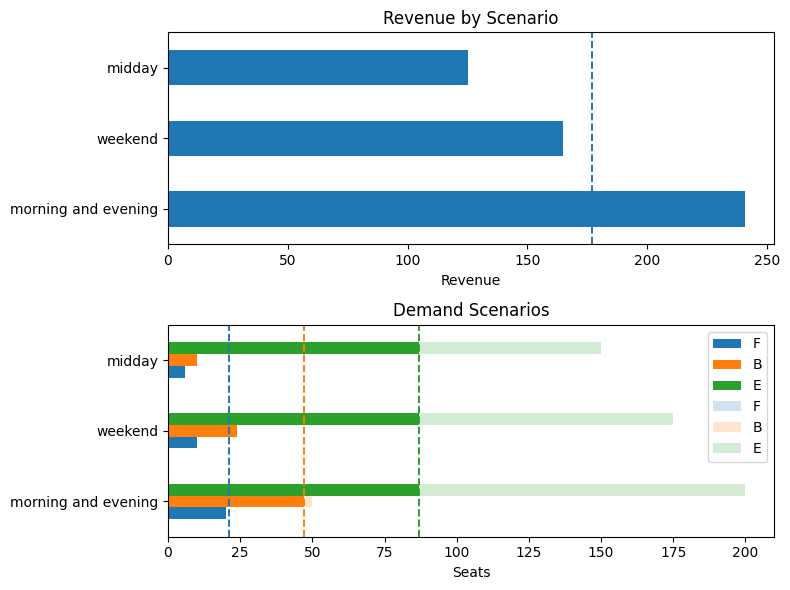

In [8]:
def airline_CC(demand):
    # create model
    m = airline_SS(demand)

    # add chance constraints
    @m.Constraint()
    def first_class(m):
        return (m.seats["F"] - mu["F"]) >= 2.054 * sigma["F"]

    # add chance constraints
    @m.Constraint()
    def business_class(m):
        return m.seats["F"]  + m.seats["B"] - (mu["F"] + mu["B"]) >= \
                1.645 * np.sqrt(sigma["F"]**2 + sigma["B"]**2)
    
    return m

# create and solve model
model_cc = airline_CC(demand)
seats_cc = airline_solve(model_cc)
seat_report(seats_cc, demand)

## Model 4. Sample Average Approximation

Now assume the ticket demand for the three categories is captured by a $3$-dimensional multivariate normal distribution mean $\mu=(\mu_F, \mu_B, \mu_E)$, variances $(\sigma_F^2, \sigma_B^2, \sigma_E^2)$ and a symmetric correlation matrix 

$$
P = \left(
\begin{array}{ccc}
1 & \rho_{FB} & \rho_{FE} \\
\rho_{BF} & 1 & \rho_{BE}\\
\rho_{EF} & \rho_{EB} & 1 \\
\end{array}
\right)
$$

The covariance matrix is given by $\Sigma = \text{diag}(\sigma)\ P\ \text{diag}(\sigma)$ or

$$
\Sigma= \left(
\begin{array}{ccc}
 \sigma_F^2 & \rho_{FB}\sigma_F\sigma_B & \rho_{FE}\sigma_F\sigma_E \\
\rho_{BF}\sigma_B\sigma_F & \sigma_B^2 & \rho_{BE}\sigma_B\sigma_E\\
\rho_{EF}\sigma_E\sigma_F & \rho_{EB}\sigma_E\sigma_B & \sigma_E^2 \\
\end{array}
\right)
$$

We assume $\rho_FB = 0.6$, $\rho_{BE} = 0.4$ and $\rho_{FE} = 0.2$.

Find an approximate solution to the airline seat allocation problem with the loyalty constraints using the Sample Average Approximation method. Sample $N=1000$ points from the multivariate normal distribution and solve the extensive form for the stochastic LP resulting from those $N=1000$ scenarios.

### Scenario Generation

,mu,sample means
F,12.0,12.058
B,28.0,28.355
E,175.0,175.436


,sigma,sample std dev
F,4,4.046852
B,16,15.879708
E,20,19.503597



Model Covariance


,F,B,E
F,16.0,38.4,16.0
B,38.4,256.0,128.0
E,16.0,128.0,400.0



Sample Covariance


,F,B,E
F,16.377013,40.352763,15.402114
B,40.352763,252.165140,121.395616
E,15.402114,121.395616,380.390294


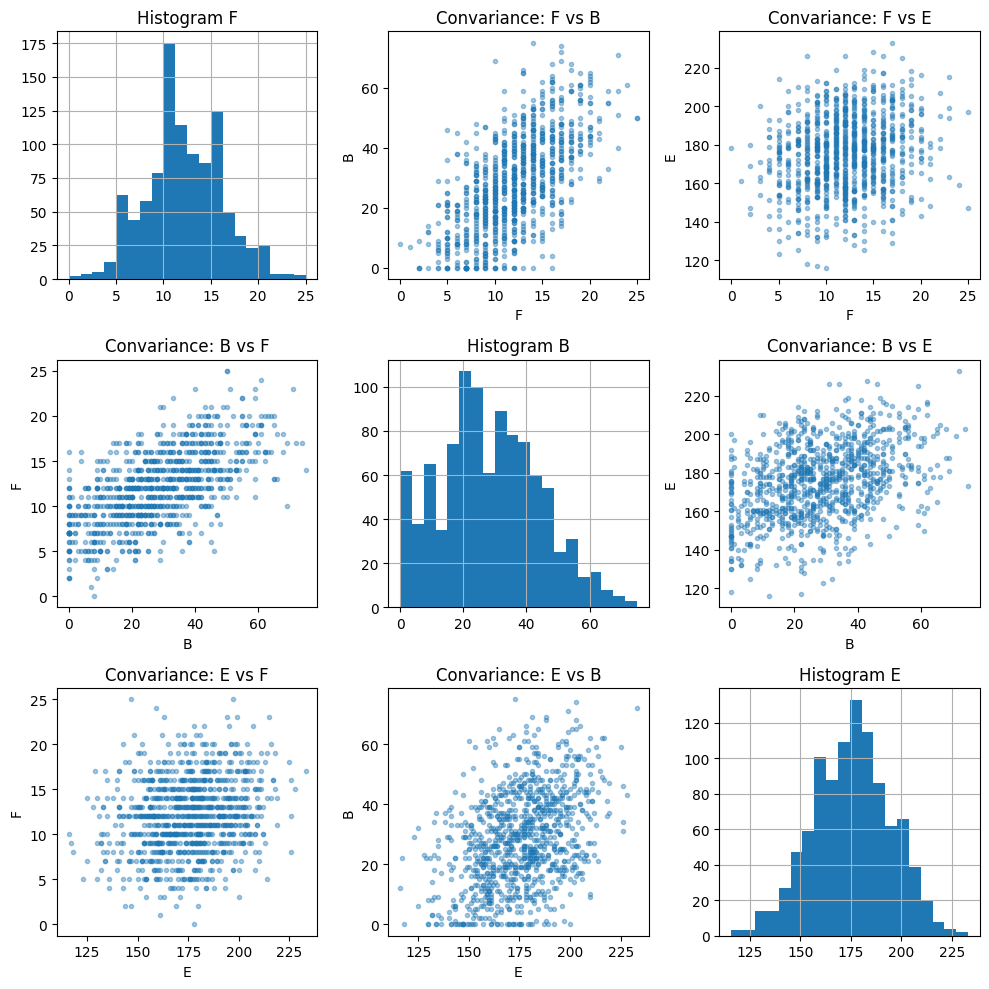

In [9]:
# sample size
N = 1000

# assume mu and sigma are given (see above)

# correlation matrix
P = np.array([[1, 0.6, 0.2], [0.6, 1, 0.4], [0.2, 0.4, 1]])

# build covariance matrix from covariances and correlations
s = np.array(list(sigma.values()))
S = np.diag(s) @ P @ np.diag(s)

# create samples
np.random.seed(1)
samples = np.random.multivariate_normal(list(mu), S, N).round()

# truncate to integers and non-negative values
classes = demand.columns
demand_saa = pd.DataFrame(samples, columns=classes)
demand_saa[demand_saa < 0] = 0

df = pd.DataFrame(mu, columns=["mu"])
df["sample means"] = demand_saa.mean()
display(df)

df = pd.DataFrame(pd.Series(sigma), columns=["sigma"])
df["sample std dev"] = demand_saa.std()
display(df)

print("\nModel Covariance")
df = pd.DataFrame(S, index=classes, columns=classes)
display(df)

print("\nSample Covariance")
display(pd.DataFrame(demand_saa.cov()))

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i, ci  in enumerate(classes):
    for j, cj in enumerate(classes):
        if i==j:
            demand_saa[ci].hist(ax=ax[i, i], bins=20)
            ax[i, i].set_title(f"Histogram {ci}")
        else:
            ax[i, j].plot(demand_saa[ci], demand_saa[cj], '.', alpha=0.4)
            ax[i, j].set_xlabel(ci)
            ax[i, j].set_ylabel(cj)
            ax[i, j].set_title(f"Convariance: {ci} vs {cj}")
fig.tight_layout()


Seat Allocation


,F,B,E,TOTAL
seat allocation,21.0,47.0,87.0,155.0
economy equivalent seat allocation,42.0,70.5,87.0,199.5



Mean Tickets Sold


F    12.035
B    27.304
E    87.000
dtype: float64


Mean Seats not Sold


F     8.965
B    19.696
E     0.000
dtype: float64


Mean Spillage (Unfulfilled Demand)


F     0.023
B     1.051
E    88.436
dtype: float64


Expected Revenue (in units of economy ticket price): 177.71


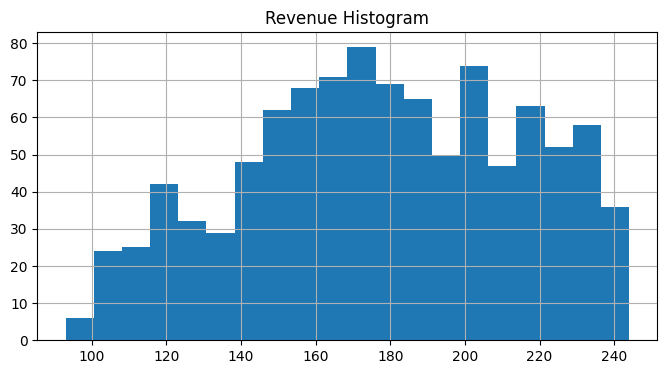

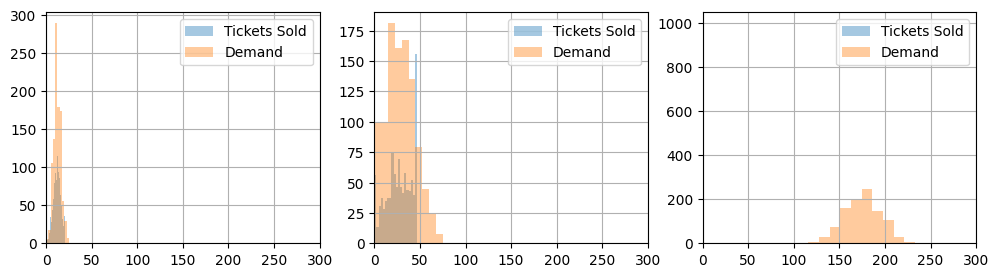

In [10]:
model_ssa = airline_CC(demand_saa)
seats_saa = airline_solve(model_ssa)

# function to report analytics for SAA case
def seat_report_saa(seats, demand):
    
    classes = seats.index
    
    # report seat allocation
    equivalent_seats = pd.DataFrame({
        "seat allocation":  {c: seats[c] for c in classes},
        "economy equivalent seat allocation": {c: seats[c] * seat_factor[c] for c in classes}
    }).T
    equivalent_seats["TOTAL"] = equivalent_seats.sum(axis=1)
    print("\nSeat Allocation")
    display(equivalent_seats)
    
    # tickets sold
    tickets = pd.DataFrame()
    for c in classes:
        tickets[c] = np.minimum(seats[c], demand[c])

    print("\nMean Tickets Sold")
    display(tickets.mean())
    
    # seats unsold
    unsold = pd.DataFrame()
    for c in classes:
        unsold[c] = seats[c] - tickets[c]
    print("\nMean Seats not Sold")
    display(unsold.mean())

    # spillage (unmet demand)
    spillage = demand - tickets
    print("\nMean Spillage (Unfulfilled Demand)")
    display(spillage.mean())
    
    # compute revenue
    revenue = tickets.dot(revenue_factor)
    print(f"\nExpected Revenue (in units of economy ticket price): {revenue.mean():.2f}")

    # charts
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    revenue.hist(ax=ax, bins=20)
    ax.set_title("Revenue Histogram")
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    for i, c in enumerate(classes):
        tickets[c].hist(ax=ax[i], bins=20, alpha=0.4)
        demand[c].hist(ax=ax[i], alpha=0.4)
        ax[i].legend(['Tickets Sold', 'Demand'])
        ax[i].set_xlim(0, 300)

    return

seat_report_saa(seats_saa, demand_saa)


## Model 5. Chance Constraints for Sample Average Approximation 

The chance constraints used used above were developed on the assumption independent Normal distributions of demand for first class and business travel. That assumption no longer holds for the case where demand scenarios are being sampled from correlated, multivariate distributions.

This final model replaces the chance constraints by explicitly tracking unsatisfied demand for first and business class seats.

$$
\begin{align}
\max & \frac{1}{N}\sum_{\substack{c\in \text{CLASSES} \\ s\in \text{SCENARIOS}}} r_c \text{tickets}_{c, s} 
\end{align}
$$

where $N$ is the number of scenarios. The first stage constraint remains unchanged

$$
\begin{align}
\sum_{c\in \text{CLASSES}} s_c \text{seats}_c & \leq \text{capacity}
\end{align}
$$

The second stage constraints are

$$
\begin{align}
\text{tickets}_c & \leq \text{seats}_c & \forall c\in \text{CLASSES} \\
\text{tickets}_c & \leq \text{demand}_{c, s} & \forall (c, s) \in \text{CLASSES} \times \text{SCENARIOS} \\
\text{seats}_F + M y_s & \geq \text{demand}_{F, s} & \forall s \in  \text{SCENARIOS}\\
\text{seats}_F + \text{seats}_B + M z_s & \geq \text{demand}_{F, s} + \text{demand}_{B,s} & \forall s \in  \text{SCENARIOS} \\
\sum_{s\in \text{SCENARIOS}} y_s & \leq 0.02 N \\
\sum_{s\in \text{SCENARIOS}} z_s & \leq 0.05 N
\end{align}
$$

where $y_s$ and $z_s$ are binary variables indicating those scenarios which do not satisfy the requirements of the airline's loyalty programs for first class and business class passengers. 

The following cell implements this new model. Note that the running time for the cell can be up to a few minutes for a large number of scenarios.


Seat Allocation


,F,B,E,TOTAL
seat allocation,20.0,54.0,79.0,153.0
economy equivalent seat allocation,40.0,81.0,79.0,200.0



Mean Tickets Sold


F    12.018
B    27.927
E    79.000
dtype: float64


Mean Seats not Sold


F     7.982
B    26.073
E     0.000
dtype: float64


Mean Spillage (Unfulfilled Demand)


F     0.040
B     0.428
E    96.436
dtype: float64


Expected Revenue (in units of economy ticket price): 170.91


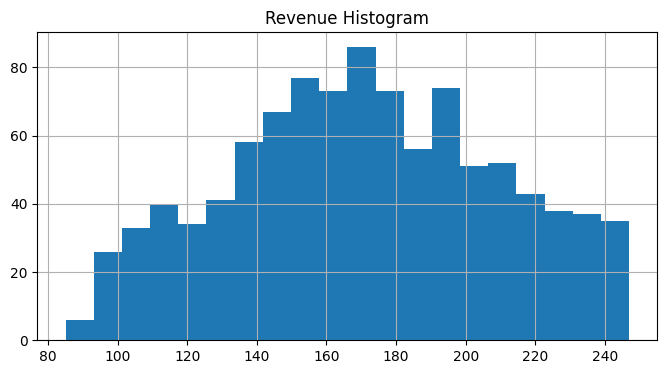

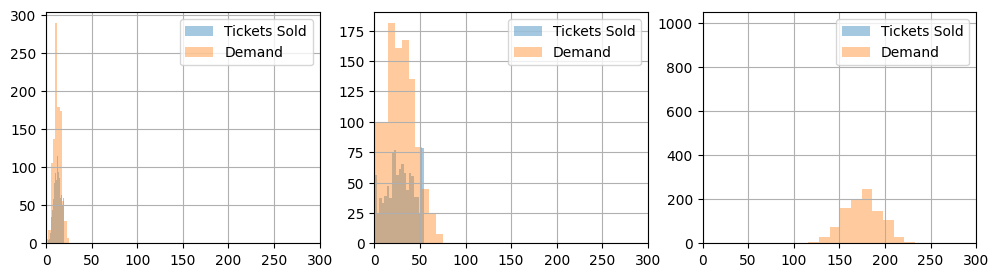

In [11]:
bigM = 100

def airline(demand):

    m = pyo.ConcreteModel()
    
    m.CLASSES = pyo.Set(initialize=demand.columns)
    m.SCENARIOS = pyo.Set(initialize=demand.index)

    # first stage variables and constraints
    m.seats = pyo.Var(m.CLASSES, domain=pyo.NonNegativeIntegers) 

    @m.Constraint(m.CLASSES)
    def plane_seats(m, c):
        return sum(m.seats[c] * seat_factor[c] for c in m.CLASSES) <= capacity

    # second stage variable and constraints
    m.tickets = pyo.Var(m.CLASSES, m.SCENARIOS, domain=pyo.NonNegativeIntegers)
    m.first_class = pyo.Var(m.SCENARIOS, domain=pyo.Binary)
    m.business_class = pyo.Var(m.SCENARIOS, domain=pyo.Binary)

    @m.Constraint(m.CLASSES, m.SCENARIOS)
    def demand_limits(m, c, s):
        return m.tickets[c, s] <= demand[c][s]

    @m.Constraint(m.CLASSES, m.SCENARIOS)
    def seat_limits(m, c, s):
        return m.tickets[c, s] <= m.seats[c]
    
    @m.Constraint(m.SCENARIOS)
    def first_class_loyality(m, s):
        return m.seats["F"] + bigM * m.first_class[s] >= demand["F"][s]
    
    @m.Constraint()
    def first_class_loyality_rate(m):
        return sum(m.first_class[s] for s in m.SCENARIOS) <= 0.02 * len(m.SCENARIOS)
    
    @m.Constraint(m.SCENARIOS)
    def business_class_loyality(m, s):
        return m.seats["F"] + m.seats["B"] + bigM * m.business_class[s] >= \
            demand["B"][s] + demand["F"][s]

    @m.Constraint()
    def business_class_loyality_rate(m):
        return sum(m.business_class[s] for s in m.SCENARIOS) <= 0.05 * len(m.SCENARIOS)
    
    # objective
    @m.Objective(sense=pyo.maximize)
    def revenue(m):
        return sum(m.tickets[c, s] * revenue_factor[c] for c in m.CLASSES for s in m.SCENARIOS)
    
    return m

# create model
model = airline(demand_saa)
seats = airline_solve(model)
seat_report_saa(seats, demand_saa)

**Exercise**

Compared the results of using positive correlation in demand for first and business class tickets results in lower expected revenue. What happens if there is no correlation, or there is negative correlation? Verify your predictions by simulation.

## Bibliographic Notes

> The aircraft rotation problem:  https://link.springer.com/content/pdf/10.1023/A:1018945415148.pdf

> SAA guide: https://people.orie.cornell.edu/shane/pubs/SAAGuide.pdf